In [7]:
import os
from pathlib import Path
from typing import Tuple
from pydub import AudioSegment
import wave
import contextlib
import shutil


# Directory to store uploaded/normalized audio files
AUDIO_DIR = Path("audio")

def is_supported_audio(filename: str) -> bool:
    """Check if the file is an MP3 or WAV file."""
    return filename.lower().endswith((".mp3", ".wav"))


def get_audio_metadata(filepath: Path) -> dict:
    """Extract metadata from WAV audio file."""
    with contextlib.closing(wave.open(str(filepath), 'rb')) as f:
        duration = f.getnframes() / float(f.getframerate())
        metadata = {
            "filename": filepath.name,
            "channels": f.getnchannels(),
            "sample_width": f.getsampwidth(),
            "frame_rate": f.getframerate(),
            "n_frames": f.getnframes(),
            "duration_sec": round(duration, 2),
        }
    return metadata


def normalize_audio(filepath: Path, output_path: Path) -> None:
    """Normalize audio and export to output path (WAV format)."""
    audio = AudioSegment.from_file(filepath)
    normalized = audio.normalize()
    normalized.export(output_path, format="wav")


def ingest_audio(file_path: str) -> Tuple[Path, dict]:
    """
    Process an uploaded audio file:
    - Save to /audio directory
    - Normalize it
    - Extract metadata
    """
    file_path = Path(file_path)
    if not file_path.exists() or not is_supported_audio(file_path.name):
        raise ValueError("Unsupported or missing file")

    # Copy to audio folder
    target_path = AUDIO_DIR / file_path.name
    shutil.copy(file_path, target_path)

    # Normalize audio
    normalized_path = AUDIO_DIR / (file_path.stem + "_normalized.wav")
    normalize_audio(target_path, normalized_path)

    # Extract metadata
    metadata = get_audio_metadata(normalized_path)
    print(f"[INFO] Audio Ingested: {metadata}")
    return normalized_path, metadata


# Example usage
if __name__ == "__main__":
    input_file = "audio_file_3.mp3"  # Replace with your local file
    try:
        normalized_audio, meta = ingest_audio(input_file)
        print("Saved to:", normalized_audio)
        print("Metadata:", meta)
    except Exception as e:
        print("Error:", e)


[INFO] Audio Ingested: {'filename': 'audio_file_3_normalized.wav', 'channels': 2, 'sample_width': 2, 'frame_rate': 44100, 'n_frames': 151238656, 'duration_sec': 3429.45}
Saved to: audio\audio_file_3_normalized.wav
Metadata: {'filename': 'audio_file_3_normalized.wav', 'channels': 2, 'sample_width': 2, 'frame_rate': 44100, 'n_frames': 151238656, 'duration_sec': 3429.45}


In [5]:
import whisper
import json
import datetime
from pathlib import Path

def transcribe_audio(audio_path: str, model_size="base", output_json=True) -> dict:
    model = whisper.load_model(model_size)
    result = model.transcribe(audio_path)

    if output_json:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        out_path = Path("transcripts")
        out_path.mkdir(exist_ok=True)
        file_path = out_path / f"{Path(audio_path).stem}_{timestamp}.json"
        with open(file_path, "w") as f:
            json.dump(result, f, indent=2)
        print(f"Saved transcript to {file_path}")

    return result

def print_transcript(transcript):
    for seg in transcript.get("segments", []):
        print(f"[{seg['start']:.2f} - {seg['end']:.2f}] {seg['text']}")

if __name__ == "__main__":
    audio = "audio/audio_file_normalized.wav"  # your audio path
    try:
        t = transcribe_audio(audio, model_size="base")
        print_transcript(t)
    except Exception as e:
        print("Transcription failed:", e)


C:\Users\INOVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcript to transcripts\audio_file_normalized_20250805_113406.json
[0.00 - 6.52]  Welcome to CASAVA Sciences Report for the second quarter of 2024.
[6.52 - 10.28]  At this time, all participants are in a listen only mode.
[10.28 - 14.68]  A question and answer session will follow the form of presentation.
[14.68 - 18.40]  As a reminder, this webcast is being recorded.
[18.40 - 23.80]  During this call and the question and answer session afterwards, representatives of CASAVA
[23.80 - 28.16]  sciences may make what are known as forward-looking statements.
[28.16 - 32.80]  A forward-looking statement is one of that is not a historical fact.
[32.80 - 39.40]  Forward-looking statements are not guarantees and they involve risks, uncertainties and assumptions.
[39.40 - 45.20]  Such statements represent current expectations or beliefs concerning future events or future
[45.20 - 46.96]  performance.
[46.96 - 53.00]  Forward-looking statements are predictions only based on upon informati

In [9]:
import json
import torch
import nltk
import pandas as pd
from pathlib import Path
from typing import List, Dict
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define a keyword scoring dictionary for custom scoring
custom_keywords = {
    "beat": 1.0,
    "miss": -1.0,
    "confident": 0.8,
    "uncertain": -0.8,
    "strong": 0.6,
    "weak": -0.6,
    "guidance": 0.5,
    "risk": -0.5,
    "growth": 0.7,
    "slowdown": -0.7,
    "challenges": -0.6,
    "record": 0.9,
    "positive": 0.5,
    "negative": -0.5
}

class SentimentAnalyzerWithKeywords:
    def __init__(self, model_name="yiyanghkust/finbert-tone"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.labels = ["positive", "negative", "neutral"]
        nltk.download("punkt", quiet=True)

    def score_keywords(self, sentence: str) -> float:
        words = sentence.lower().split()
        score = sum(custom_keywords.get(word, 0) for word in words)
        return round(score, 2)

    def analyze_sentences(self, sentences: List[str]) -> List[Dict]:
        results = []
        for sentence in sentences:
            inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                max_index = torch.argmax(probs).item()
                sentiment = self.labels[max_index]
                confidence = round(probs[0][max_index].item(), 3)
                keyword_score = self.score_keywords(sentence)

            results.append({
                "sentence": sentence,
                "finbert_sentiment": sentiment,
                "confidence": confidence,
                "keyword_score": keyword_score
            })
        return results

    def analyze_text(self, text: str) -> pd.DataFrame:
        sentences = sent_tokenize(text)
        results = self.analyze_sentences(sentences)
        return pd.DataFrame(results)

    def analyze_whisper_json(self, json_path: str) -> pd.DataFrame:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        segments = data.get("segments", [])
        sentences = [seg.get("text", "").strip() for seg in segments]
        return pd.DataFrame(self.analyze_sentences(sentences))


if __name__ == "__main__":
    analyzer = SentimentAnalyzerWithKeywords()

    # Example 2: Analyze Whisper JSON transcript
    df = analyzer.analyze_whisper_json("transcripts/audio_file_normalized.json")
    df.to_csv("output_sentiment_from_whisper.csv", index=False)


C:\Users\INOVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


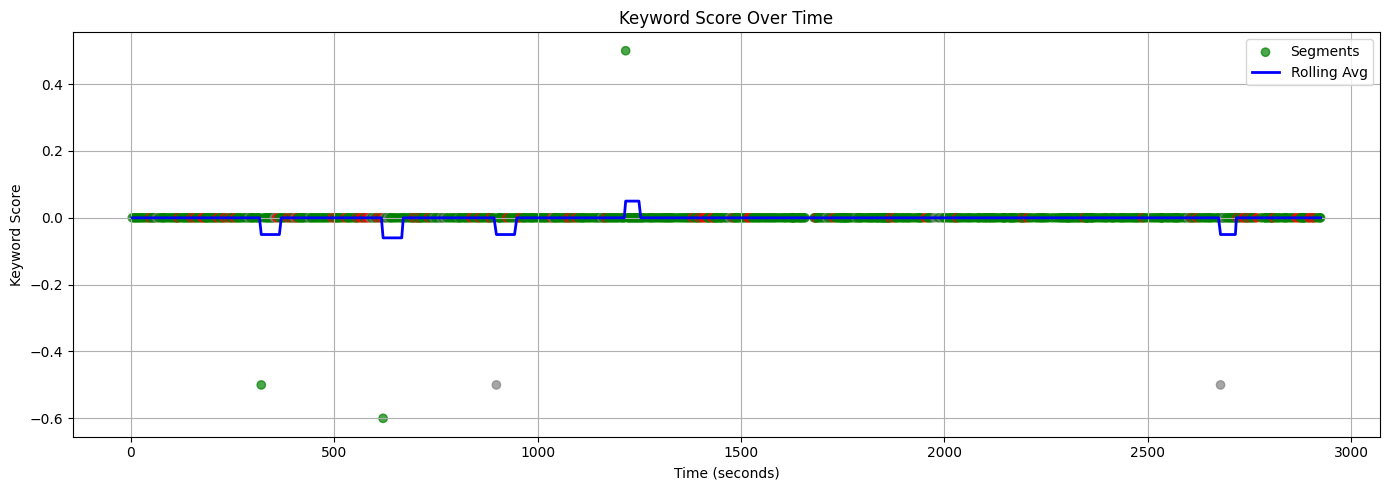

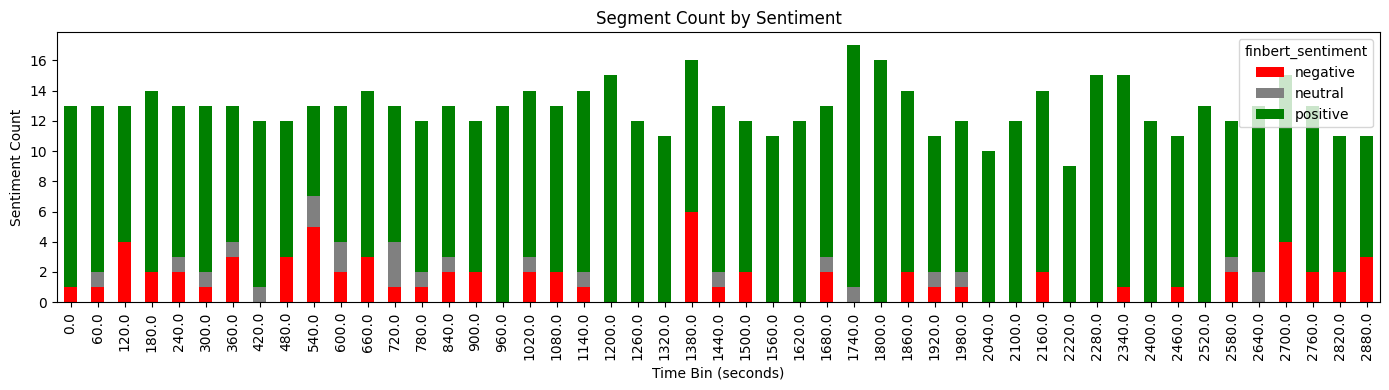

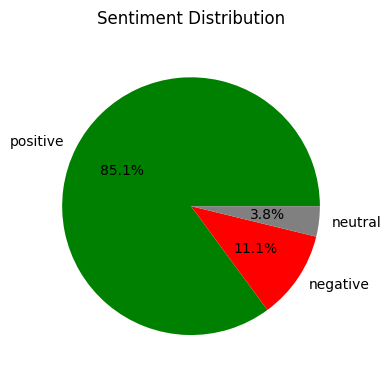

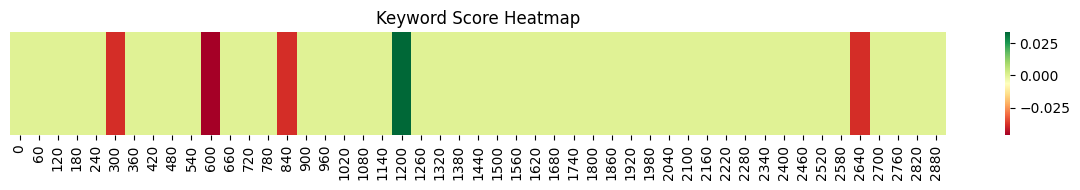


🔍 Segment Table Preview:
   start    end                                           sentence  \
0   0.00   6.52  Welcome to CASAVA Sciences Report for the seco...   
1   6.52  10.28  At this time, all participants are in a listen...   
2  10.28  14.68  A question and answer session will follow the ...   
3  14.68  18.40     As a reminder, this webcast is being recorded.   
4  18.40  23.80  During this call and the question and answer s...   
5  23.80  28.16  sciences may make what are known as forward-lo...   
6  28.16  32.80  A forward-looking statement is one of that is ...   
7  32.80  39.40  Forward-looking statements are not guarantees ...   
8  39.40  45.20  Such statements represent current expectations...   
9  45.20  46.96                                       performance.   

  finbert_sentiment  confidence  keyword_score  
0          positive       0.999            0.0  
1          positive       1.000            0.0  
2          positive       1.000            0.0  
3      

In [18]:
%matplotlib inline
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
transcript_json = "transcripts/audio_file_normalized.json"
sentiment_csv = "output_sentiment_from_whisper.csv"

try:
    # Load transcript and sentiment data
    with open(transcript_json, "r", encoding="utf-8") as f:
        whisper = json.load(f)
    df = pd.read_csv(sentiment_csv)

    # Extract segment timestamps
    segments = whisper["segments"]
    df["start"] = [s["start"] for s in segments[:len(df)]]
    df["end"] = [s["end"] for s in segments[:len(df)]]
    df["midpoint"] = (df["start"] + df["end"]) / 2
    df = df.sort_values("midpoint")

    # Settings
    score_type = "keyword_score"   # or "confidence"
    window = 10                     # rolling average window
    bin_size = 60                  # time bin in seconds
    sentiment_filter = ["positive", "negative", "neutral"]

    df = df[df["finbert_sentiment"].isin(sentiment_filter)]
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}

    # Plot 1 – Score Timeline
    plt.figure(figsize=(14, 5))
    plt.scatter(df["midpoint"], df[score_type],
                c=df["finbert_sentiment"].map(colors), alpha=0.7, label="Segments")
    plt.plot(df["midpoint"],
             df[score_type].rolling(window=window, min_periods=1).mean(),
             color="blue", linewidth=2, label="Rolling Avg")
    plt.title(f"{score_type.replace('_',' ').title()} Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel(score_type.replace("_", " ").title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2 – Sentiment count over time
    df["time_bin"] = (df["midpoint"] // bin_size) * bin_size
    count_df = df.groupby(["time_bin", "finbert_sentiment"]).size().reset_index(name="count")
    pivot_df = count_df.pivot(index="time_bin", columns="finbert_sentiment", values="count").fillna(0)
    pivot_df.plot(kind="bar", stacked=True, figsize=(14, 4), color=colors)
    plt.xlabel("Time Bin (seconds)")
    plt.ylabel("Sentiment Count")
    plt.title("Segment Count by Sentiment")
    plt.tight_layout()
    plt.show()

    # Plot 3 – Sentiment Distribution Pie
    sentiment_counts = df["finbert_sentiment"].value_counts()
    plt.figure(figsize=(4, 4))
    plt.pie(sentiment_counts, labels=sentiment_counts.index,
            autopct="%1.1f%%", colors=[colors[k] for k in sentiment_counts.index])
    plt.title("Sentiment Distribution")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    # Plot 4 – Heatmap of Keyword Score
    df_heat = df[["midpoint", "keyword_score"]].copy()
    df_heat["bin"] = (df_heat["midpoint"] // bin_size) * bin_size
    heat = df_heat.groupby("bin").mean().reset_index()
    plt.figure(figsize=(12, 2))
    sns.heatmap([heat["keyword_score"].tolist()],
                cmap="RdYlGn", cbar=True,
                xticklabels=heat["bin"].astype(int).tolist())
    plt.title("Keyword Score Heatmap")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

    # Table – print first few rows
    print("\n🔍 Segment Table Preview:")
    print(df[["start", "end", "sentence", "finbert_sentiment", "confidence", "keyword_score"]].head(10))

except Exception as e:
    print(f"❌ Failed to load or process data: {e}")


In [3]:
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import os

def extract_features(audio_path, frame_length=2048, hop_length=512, silence_thresh_db=-40):
    # Load audio
    try:
        y, sr = librosa.load(audio_path, sr=None)
    except FileNotFoundError:
        raise FileNotFoundError(f"Audio file '{audio_path}' not found.")
    except Exception as e:
        raise RuntimeError(f"Could not load audio file: {e}")

    # Extract pitch (fundamental frequency)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr, hop_length=hop_length)
    pitch = []
    for i in range(pitches.shape[1]):
        index = magnitudes[:, i].argmax()
        pitch_val = pitches[index, i]
        pitch.append(pitch_val if pitch_val > 0 else np.nan)
    pitch = np.array(pitch)

    # Short-time energy
    energy = np.array([
        np.sum(np.abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    # Convert energy to dB
    energy_db = librosa.amplitude_to_db(np.sqrt(energy + 1e-6))

    # Silence detection
    silence_mask = energy_db < silence_thresh_db
    num_silence_frames = np.sum(silence_mask)
    silence_duration = num_silence_frames * hop_length / sr
    total_duration = len(y) / sr
    pause_rate = num_silence_frames / len(energy_db)

    # Timestamps for frames
    times = librosa.frames_to_time(np.arange(len(energy_db)), sr=sr, hop_length=hop_length)

    # Prepare DataFrame
    df = pd.DataFrame({
        "time": times,
        "pitch": pitch[:len(times)],
        "energy_db": energy_db,
        "is_silence": silence_mask
    })

    # Summary features
    features_summary = {
        "mean_pitch": np.nanmean(pitch),
        "std_pitch": np.nanstd(pitch),
        "mean_energy_db": np.mean(energy_db),
        "std_energy_db": np.std(energy_db),
        "silence_duration_sec": silence_duration,
        "pause_rate": pause_rate,
        "total_duration_sec": total_duration
    }

    return df, features_summary

# Example usage
audio_file = "audio/audio_file_normalized.wav"  # Replace with your actual file
df_features, summary = extract_features(audio_file)

# Save outputs
df_features.to_csv("frame_level_features.csv", index=False)
pd.DataFrame([summary]).to_csv("summary_features.csv", index=False)

print("Features saved:")
print("- frame_level_features.csv")
print("- summary_features.csv")


Features saved:
- frame_level_features.csv
- summary_features.csv


In [8]:
import parselmouth
from parselmouth.praat import call
import librosa
import numpy as np
import pandas as pd
import os

def extract_prosodic_features(audio_path):
    # Load audio with librosa for hesitation detection
    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)

    # Load audio in Parselmouth for prosody analysis
    sound = parselmouth.Sound(audio_path)

    # Pitch
    pitch_obj = call(sound, "To Pitch", 0.0, 75, 600)
    pitch_values = pitch_obj.selected_array['frequency']
    pitch_values = pitch_values[pitch_values != 0]  # Remove unvoiced frames
    mean_pitch = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    min_pitch = np.min(pitch_values) if len(pitch_values) > 0 else 0
    max_pitch = np.max(pitch_values) if len(pitch_values) > 0 else 0

    # Intensity
    intensity_obj = call(sound, "To Intensity", 100.0, 0.0)
    mean_intensity = call(intensity_obj, "Get mean", 0, 0, "energy")
    min_intensity = call(intensity_obj, "Get minimum", 0, 0, "Parabolic")
    max_intensity = call(intensity_obj, "Get maximum", 0, 0, "Parabolic")

    # Jitter & Shimmer
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 600)
    local_jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    local_shimmer = call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    # Harmonicity (HNR)
    harmonicity_obj = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity_obj, "Get mean", 0, 0)

    # Speech rate
    syllable_count = 0
    intensity_values = intensity_obj.values[0]
    threshold = np.mean(intensity_values) * 0.6
    for i in range(1, len(intensity_values) - 1):
        if intensity_values[i] > threshold and intensity_values[i] > intensity_values[i-1] and intensity_values[i] > intensity_values[i+1]:
            syllable_count += 1
    speech_rate = syllable_count / duration if duration > 0 else 0

    # Hesitation detection
    non_silent_intervals = librosa.effects.split(y, top_db=30)
    hesitations = 0
    for i in range(1, len(non_silent_intervals)):
        pause_duration = (non_silent_intervals[i][0] - non_silent_intervals[i-1][1]) / sr
        if pause_duration > 0.3:
            hesitations += 1

    # Store features with filename
    features = {
        "file_name": os.path.basename(audio_path),
        "mean_pitch": mean_pitch,
        "min_pitch": min_pitch,
        "max_pitch": max_pitch,
        "mean_intensity": mean_intensity,
        "min_intensity": min_intensity,
        "max_intensity": max_intensity,
        "jitter": local_jitter,
        "shimmer": local_shimmer,
        "hnr": hnr,
        "speech_rate": speech_rate,
        "hesitations": hesitations,
        "duration": duration
    }
    
    return features

# Process multiple files
audio_files = [
    "audio/audio_file_normalized.wav",
    "audio/audio_file_2_normalized.wav",
    "audio/audio_file_3_normalized.wav"
]

all_features = []
for file in audio_files:
    print(f"🔍 Processing {file} ...")
    all_features.append(extract_prosodic_features(file))

# Save all results to one CSV
df = pd.DataFrame(all_features)
df.to_csv("prosodic_features_all.csv", index=False)

print("✅ Prosodic features for all files saved to prosodic_features_all.csv")
print(df)


🔍 Processing audio/audio_file_normalized.wav ...
🔍 Processing audio/audio_file_2_normalized.wav ...
🔍 Processing audio/audio_file_3_normalized.wav ...
✅ Prosodic features for all files saved to prosodic_features_all.csv
                     file_name  mean_pitch  min_pitch   max_pitch  \
0    audio_file_normalized.wav  139.513486  74.938922  599.899406   
1  audio_file_2_normalized.wav  136.004133  74.945880  599.981049   
2  audio_file_3_normalized.wav  136.176381  74.939399  599.744773   

   mean_intensity  min_intensity  max_intensity    jitter   shimmer       hnr  \
0       71.864713      14.178763      91.069539  0.026646  0.165420  8.673204   
1       70.995858    -331.737519      86.359299  0.023443  0.106642  9.738677   
2       63.090276    -332.708862      80.362135  0.020730  0.114324  9.741132   

   speech_rate  hesitations     duration  
0    13.365295         1040  2925.412426  
1    11.609935          740  3278.657596  
2    10.291161          802  3429.447982  


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



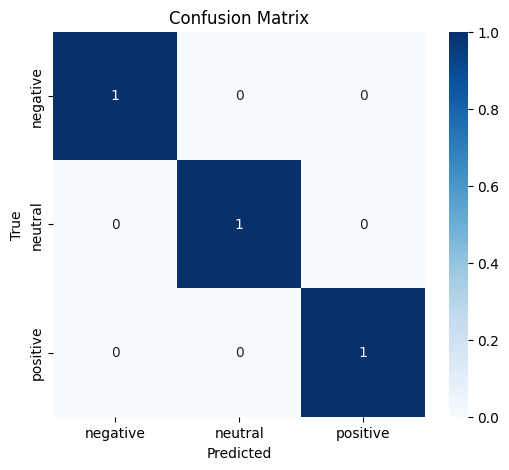

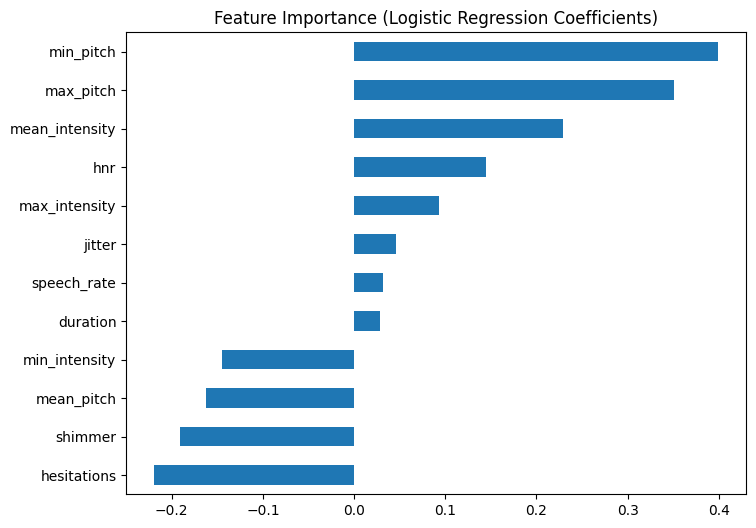

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load Prosodic Features ===
df = pd.read_csv("prosodic_features_all.csv")

# Example: make sure you have a target column (label)
# If you don’t have it, create one manually for testing:
# df['label'] = ['positive', 'negative', 'neutral']  # example

if 'label' not in df.columns:
    raise ValueError("No 'label' column found. Please add labels for supervised learning.")

# === 2. Select Features ===
features = [
    "mean_pitch", "min_pitch", "max_pitch",
    "mean_intensity", "min_intensity", "max_intensity",
    "jitter", "shimmer", "hnr",
    "speech_rate", "hesitations", "duration"
]

X = df[features]
y = df['label']

# === 3. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Feature Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Train Model ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# === 6. Predictions & Evaluation ===
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# === 7. Feature Importance ===
importance = pd.Series(model.coef_[0], index=features)
importance.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()


Cross-Validation Accuracy: 100.00% ± 0.00
Test Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



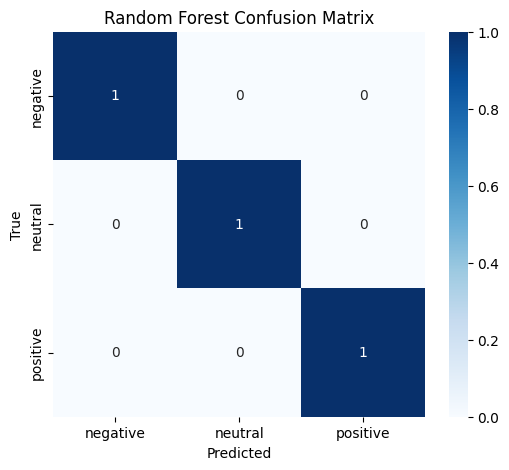

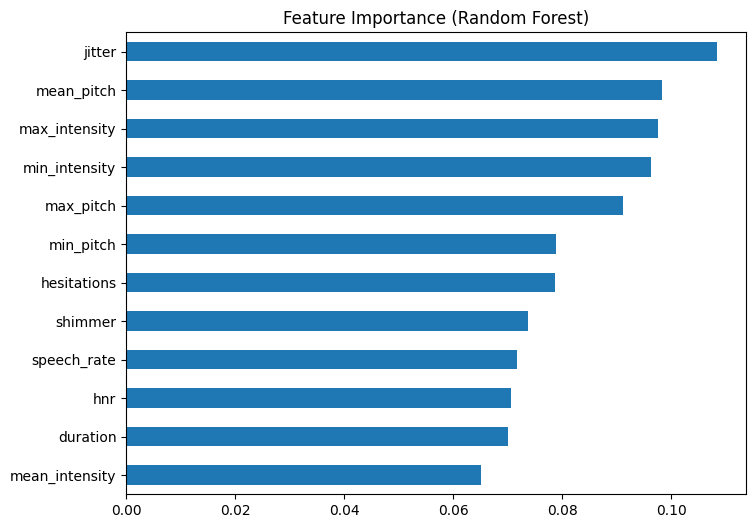

✅ Model saved as prosodic_model.pkl


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# === 1. Load Prosodic Features ===
df = pd.read_csv("prosodic_features_all.csv")

# Ensure label column exists
if 'label' not in df.columns:
    raise ValueError("No 'label' column found. Please add labels for supervised learning.")

# === 2. Select Features ===
features = [
    "mean_pitch", "min_pitch", "max_pitch",
    "mean_intensity", "min_intensity", "max_intensity",
    "jitter", "shimmer", "hnr",
    "speech_rate", "hesitations", "duration"
]

X = df[features]
y = df['label']

# === 3. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Feature Scaling (Optional for RF, but helps if features vary widely) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Train Random Forest Model ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_scaled, y_train)

# === 6. Cross-Validation Accuracy ===
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=2)
print("Cross-Validation Accuracy: {:.2f}% ± {:.2f}".format(cv_scores.mean()*100, cv_scores.std()*100))

# === 7. Predictions & Evaluation ===
y_pred = rf_model.predict(X_test_scaled)
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# === 8. Feature Importance Plot ===
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Random Forest)")
plt.show()

joblib.dump(rf_model, "prosodic_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model saved as prosodic_model.pkl")

In [21]:
new_features = {
    "mean_pitch": 180.5,
    "min_pitch": 90.0,
    "max_pitch": 260.0,
    "mean_intensity": 70.2,
    "min_intensity": 50.1,
    "max_intensity": 85.0,
    "jitter": 0.005,
    "shimmer": 0.04,
    "hnr": 20.0,
    "speech_rate": 4.5,
    "hesitations": 2,
    "duration": 5.2
}

# Load model & scaler
rf_model = joblib.load("prosodic_model.pkl")
scaler = joblib.load("scaler.pkl")

# Prepare input
import numpy as np
input_data = np.array([[new_features[f] for f in features]])
input_scaled = scaler.transform(input_data)

# Predict
predicted_label = rf_model.predict(input_scaled)[0]
print(f"🎯 Predicted Class: {predicted_label}")


🎯 Predicted Class: negative


C:\Users\INOVA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
